# Getting Started with `feems`

This notebook illustrates a minimal example of how to run `feems` on a dataset of North American gray wolves published in [Schweizer et al. 2015](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW).

## Imports

First we import the required packages and `feems`:

In [1]:
# base
import math
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
import pickle

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective, query_node_attributes
from feems.cross_validation import run_cv, comp_mats



# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Data

Note we have packaged this example dataset in the `feems` package and use the `pkg_resources` package to find the path of those files:

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [3]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)
n, p = genotypes.shape

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 49.77it/s]

n_samples=111, n_snps=17729


As we can see we have 111 samples and 17,729 SNPs. For preparing the graph inputs to run `feems` you have two options:

* Prepare your own input files
* Use the `feems` function `prepare_graph_inputs` which intersects a discrete global grid (DGG) with the sample range

We'll show off the later option. We read the sample coordinates (`coords`), coordinates of the outer polygon that defines the habitat of the sample  (`outer`) and a discrete global grid file which has laid down a triangular grid that is uniformly spaced on earth (`grid_path`). We then intersect this global grid with the outer file to define the graph that we use to optimize (`edges` and `grid`):

In [4]:
%%time
# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 5.18 s, sys: 70.2 ms, total: 5.25 s
Wall time: 5.28 s


Lets take a peek at each of these inputs:

In [6]:
outer[:5, ]

array([[-126.2547116,   48.6329086],
       [-127.5731488,   49.1817034],
       [-128.9351421,   50.1205781],
       [-130.2099765,   50.930738 ],
       [-131.8797738,   51.8900539]])

In [7]:
edges[:5, ]

array([[838, 839],
       [357, 386],
       [605, 637],
       [536, 537],
       [136, 158]])

In [8]:
grid[:5, ]

array([[-166.637,   59.732],
       [-166.585,   60.675],
       [-166.529,   61.623],
       [-168.75 ,   62.088],
       [-166.467,   62.576]])

## Setup the `SpatialGraph` object

We then setup the `SpatialGraph` object which is the core workhorse of `feems`. `SpatialGraph` specifies the graph, allele frequency data, and runs the optimizers to fit the edge weights of the graph:

In [5]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

CPU times: user 1min 51s, sys: 2.94 s, total: 1min 54s
Wall time: 1min 54s


Minimum eigenvalue: 0.3986124936141127
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430


81

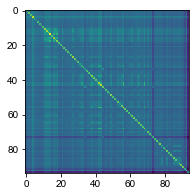

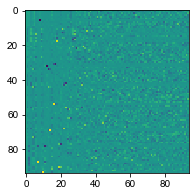

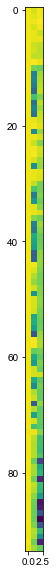

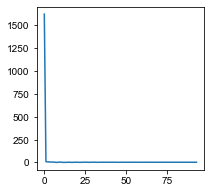

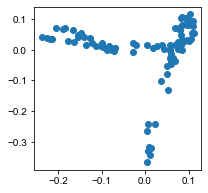

In [54]:
fig = plt.figure(figsize = [3,3])
ax1 = fig.add_subplot(111)
ax1.imshow(sp_graph.S, interpolation='nearest')

from numpy import linalg as LA
w, v = LA.eig(sp_graph.S)

fig = plt.figure(figsize = [3,3])
ax1 = fig.add_subplot(111)
ax1.imshow(v, interpolation='nearest')

fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(111)
ax1.imshow(v[0:n,:3], interpolation='nearest')

fig = plt.figure(figsize = [3,3])
ax1 = fig.add_subplot(111)
ax1.plot(range(0,len(w)),w)
print("Minimum eigenvalue: {}".format(min(w)))

fig = plt.figure(figsize = [3,3])
ax1 = fig.add_subplot(111)
ax1.scatter(v[0:n,1],v[0:n,2])


#sp_graph.fit_null_model()

obj = Objective(sp_graph)
from scipy.optimize import fmin_l_bfgs_b, minimize
from feems import Objective, loss_wrapper, neg_log_lik_w0_s2
import sys
res = minimize(neg_log_lik_w0_s2, [0.0, 0.0], method="Nelder-Mead", args=(obj))
assert res.success is True, "did not converge"
w0_hat = np.exp(res.x[0])
s2_hat = np.exp(res.x[1])
sp_graph.w0 = w0_hat * np.ones(sp_graph.w.shape[0])
sp_graph.s2 = s2_hat
sp_graph.comp_precision(s2=s2_hat)

# print update
sp_graph.train_loss = neg_log_lik_w0_s2(np.r_[np.log(w0_hat), np.log(s2_hat)], obj)

sys.stdout.write(
    (
        "constant-w/variance fit, "
        "converged in {} iterations, "
        "train_loss={:.7f}\n"
    ).format(res.nfev, sp_graph.train_loss)
)

This might take a few minutes to construct at first b/c it initializing a number of graph matrices that are slow to build. First, before any fitting we'll visualize the graph and samples. Let's setup the projection we'll be using for this dataset:

In [10]:
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)

Now lets make a map of the sample coordinates, graph and observed nodes:

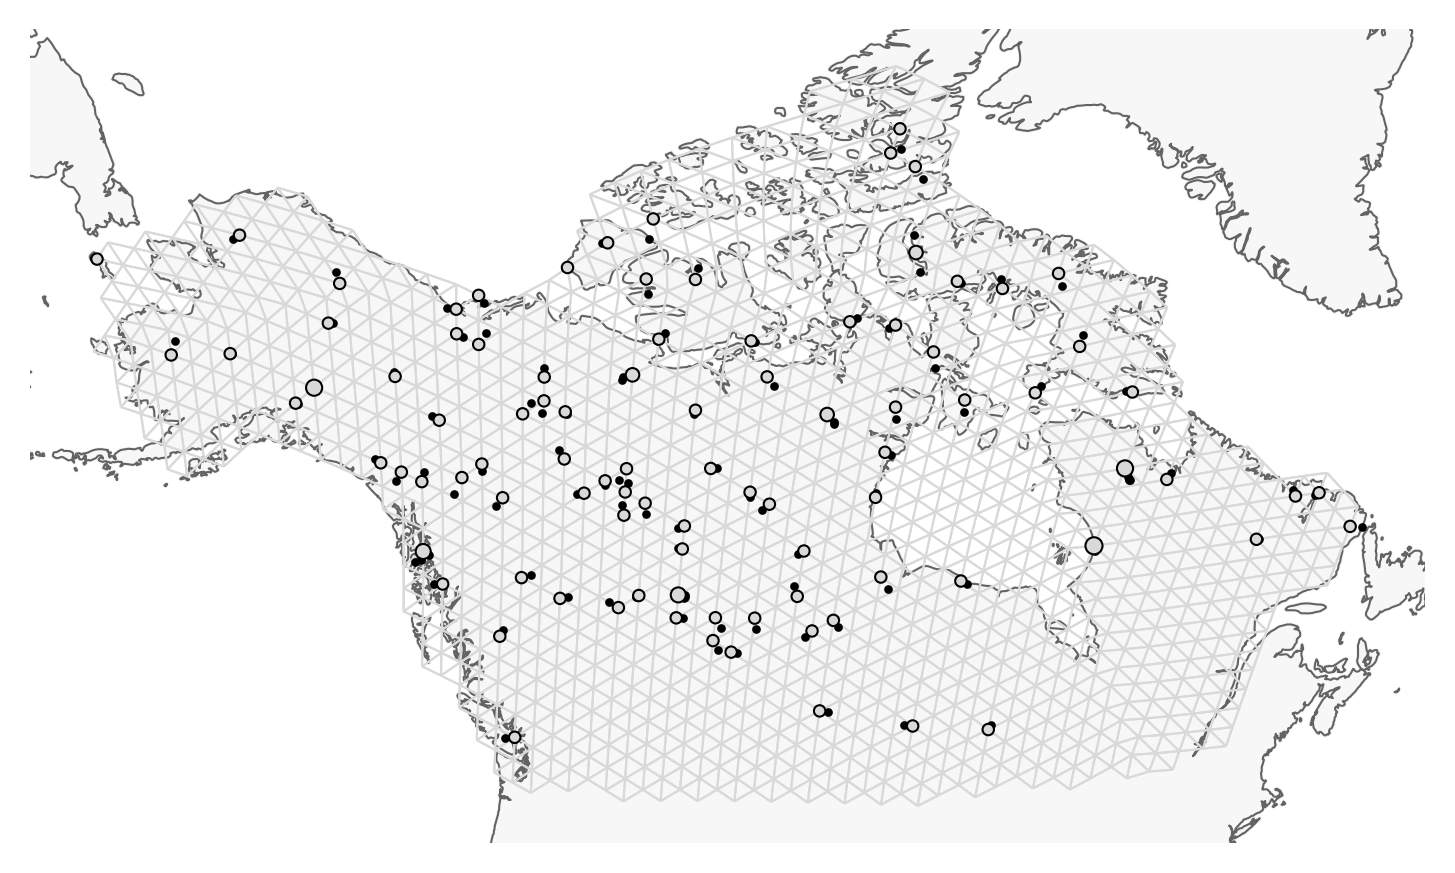

In [11]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

The black points are the observed locations for each sample and the gray points show the nodes that samples were assigned to. The gray lines represent the graph that will be fitted.

## Fit `feems` with cross-validation

We'll fit FEEMS across a grid of possible regularization values and choose the one that minimizes the cross-validation error.  This will take approximately 15 minutes on a single CPU.  If you want to skip this step for time reasons, you can set 'LoadCVFromDisk' in the second code block (or set lamb_cv to 0.77 manually) and skip ahead past this code block and the next.

In [12]:
%%time
LoadCVFromDisk = True

# define grid
# Publication-quality grid for this dataset
#lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
# Exploratory grid: 
lamb_grid = np.geomspace(1e-4, 1e1, 10)[::-1]

# run cross-validation
if not LoadCVFromDisk:
    cv_err = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e10)
    pickle.dump(cv_err,open("cv_err.pkl","wb"))

CPU times: user 237 µs, sys: 29 µs, total: 266 µs
Wall time: 243 µs


Now we plot the CV error:

0.7742636826811278

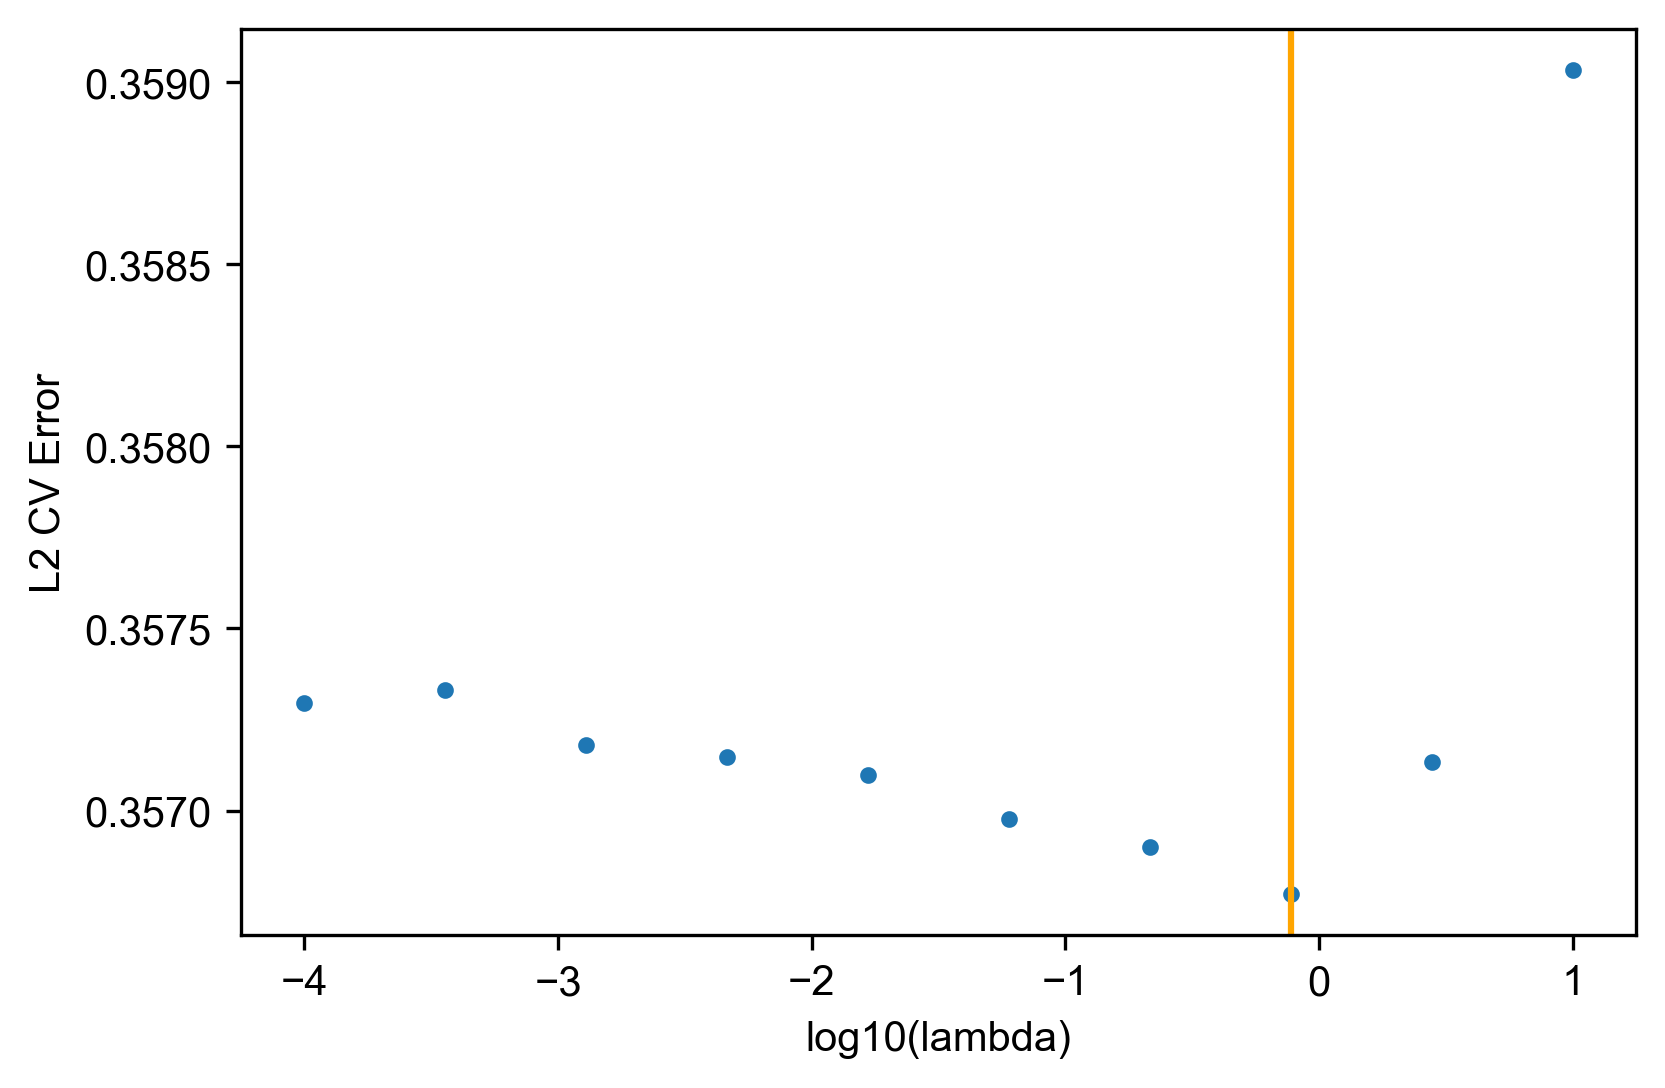

In [13]:
LoadCVFromDisk = True
if LoadCVFromDisk: 
    cv_err = pickle.load(open("cv_err.pkl","rb"))
    
# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

fig, ax = plt.subplots(dpi=300)
ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("L2 CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange")
lamb_cv

And then we can refit the model the lambda we found above that minimizes the cross-validation error ('lamb_cv'), and plot the result.

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.7742637, alpha=0.8354260, converged in 98 iterations, train_loss=2761134.7542283


Text(0.5, 0, 'residuals')

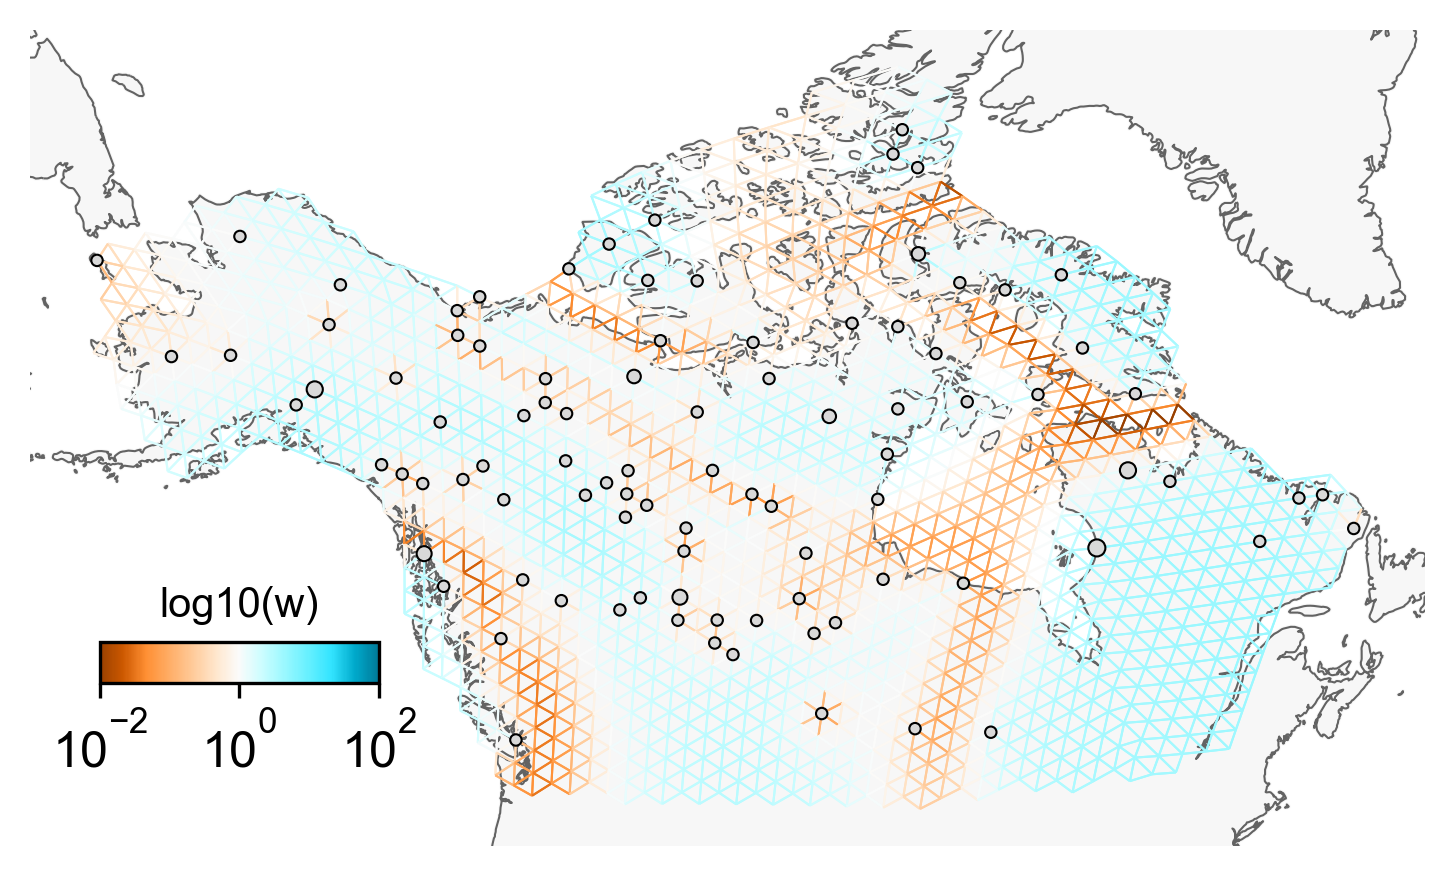

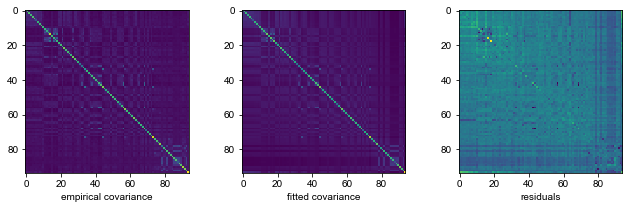

In [14]:
# re-fit
sp_graph.fit(lamb_cv)

# Plot the FEEMS result
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()


# Plot Observed vs Fitted Covarainces
obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fig = plt.figure(figsize = [11,3])
ax1 = fig.add_subplot(131)
ax1.imshow(emp_cov, interpolation='nearest')
ax1.set_xlabel("empirical covariance")
ax2 = fig.add_subplot(132)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(fit_cov, interpolation='nearest')
ax2.set_xlabel("fitted covariance")
ax3 = fig.add_subplot(133)
# 'nearest' interpolation - faithful but blocky
ax3.imshow(fit_cov-emp_cov, interpolation='nearest')
ax3.set_xlabel("residuals")

## Comparing the fitted distances model to geographic distances and a "simple" isolation-by-distance mdoel

We next want to inspect how these spatial models perform in terms of representing the genetic distances in the data.  Let's produce a figure showing observed genetic distances vs great circle geographic distances, vs distances in a model fit with constant migration weights (w), and vs the distances fitted in the model with varying w and regularization matching our cross-validation chosen value of $\lambda$.  

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.7742637, alpha=0.8354260, converged in 98 iterations, train_loss=2761134.7611141
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.0007743, alpha=0.8354260, converged in 1134 iterations, train_loss=2744783.7107543


Text(0, 0.5, 'genetic distance')

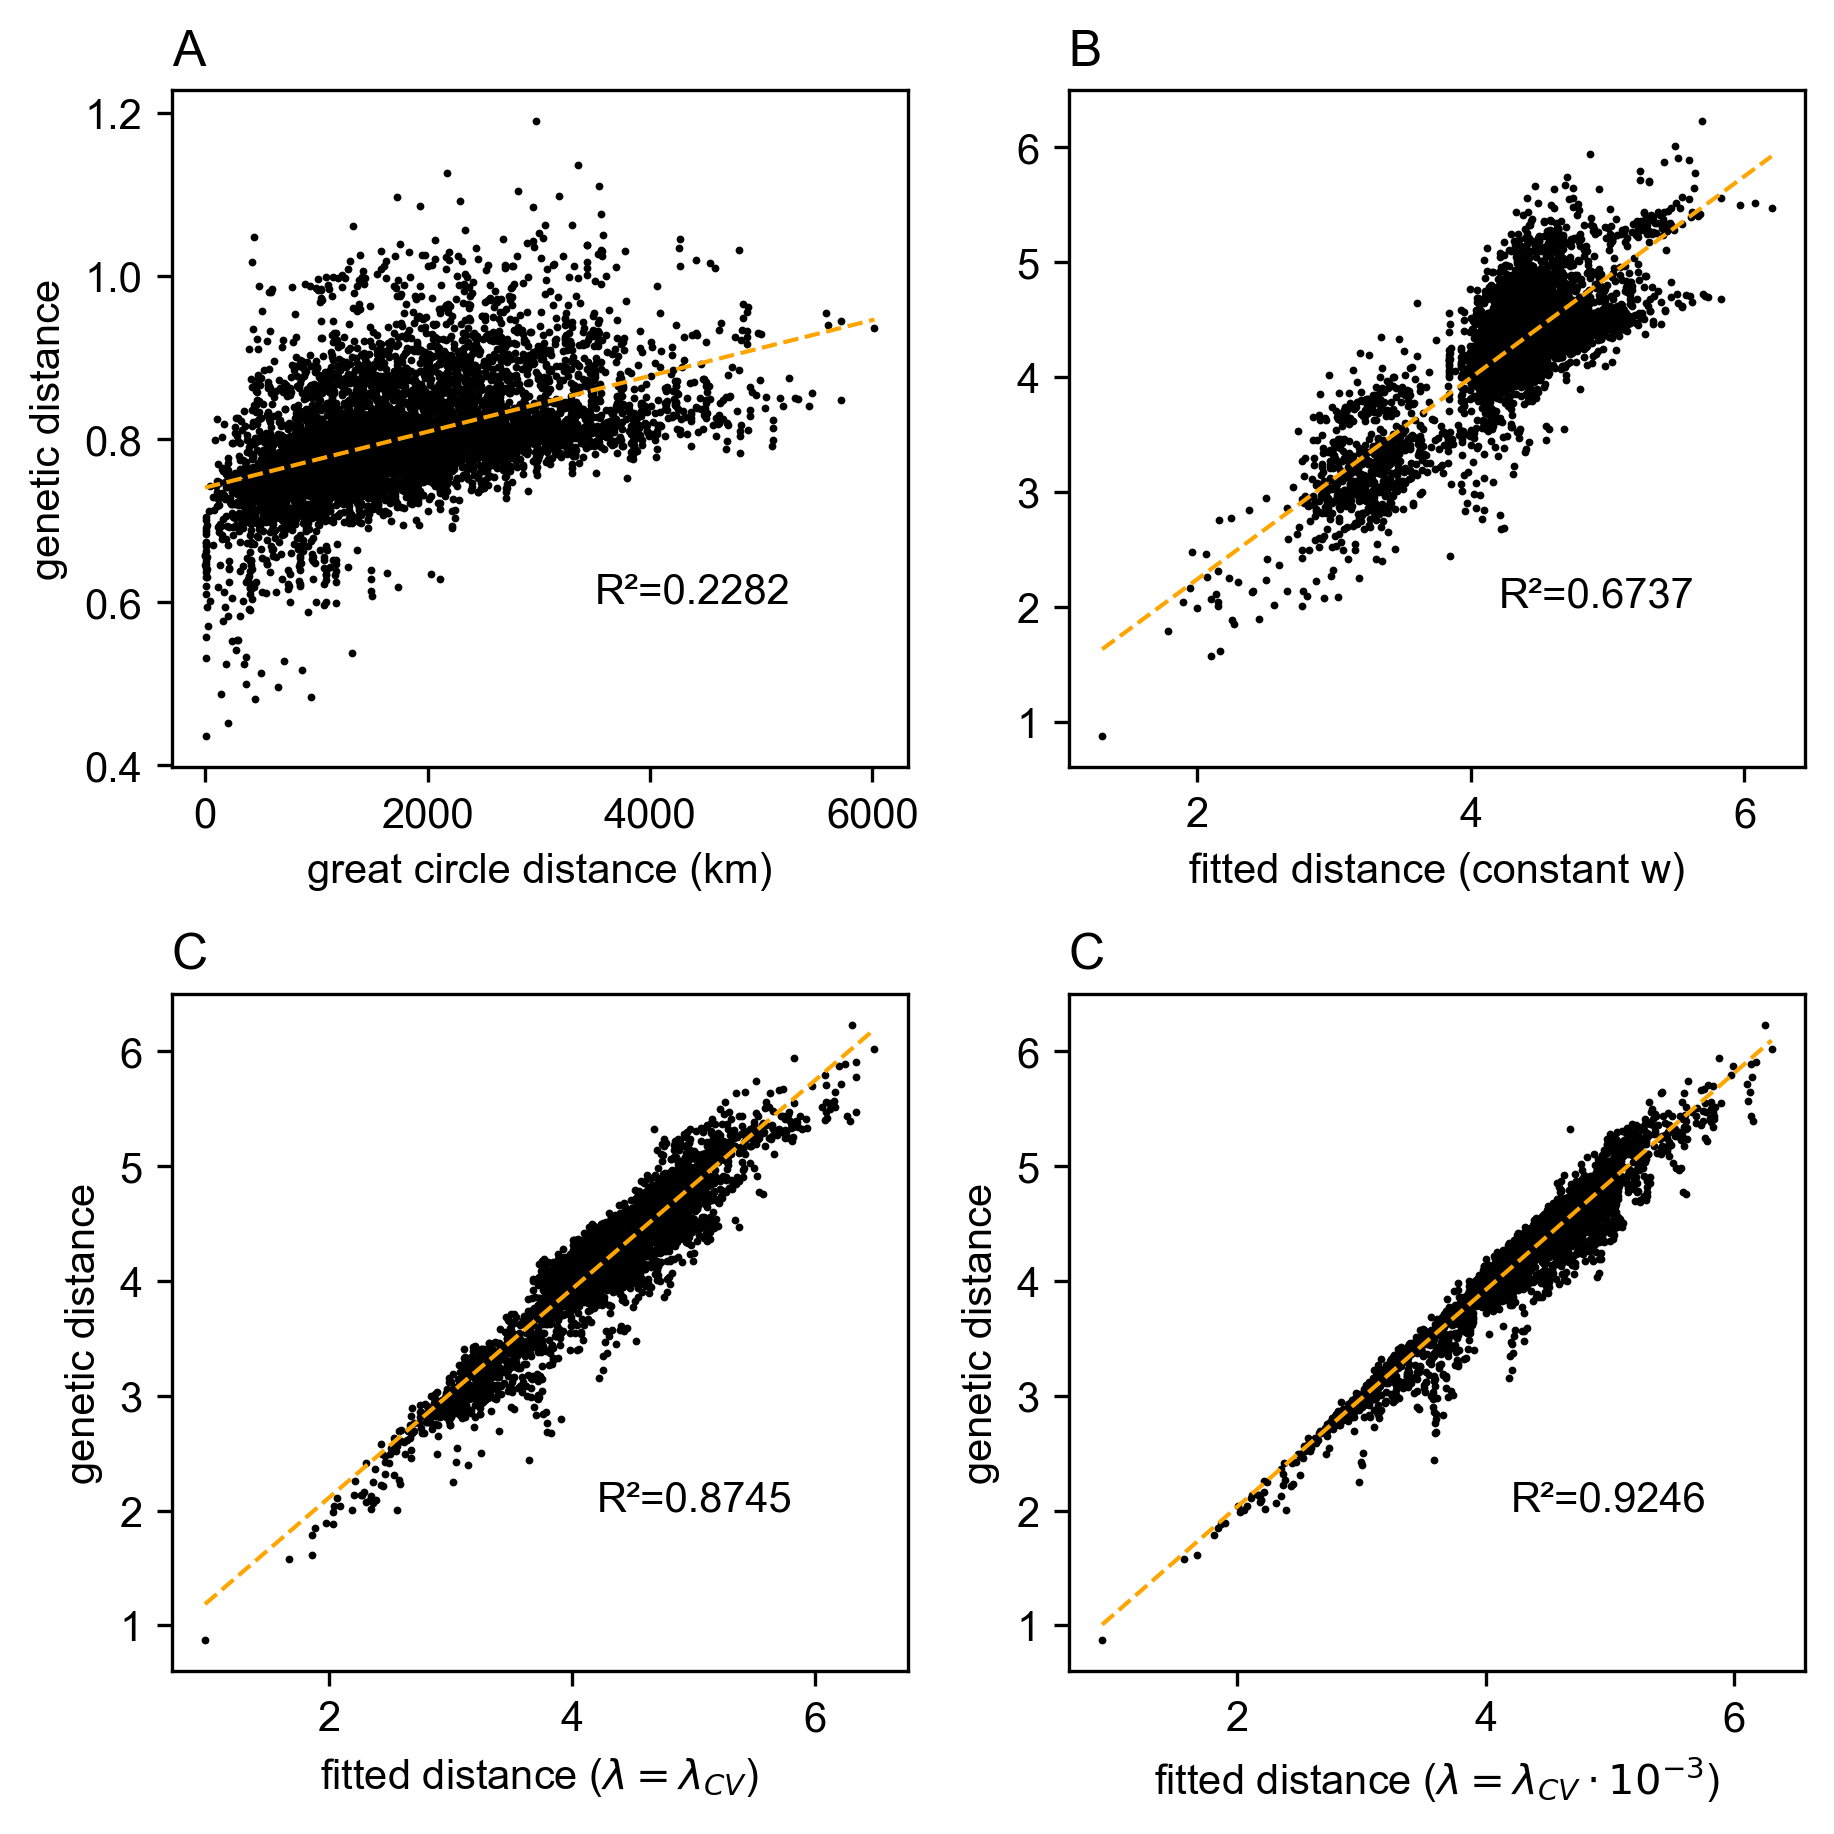

In [15]:

def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

# Initialize figure
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(6, 6))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# (A) Genetic distance vs geographic distance
D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / p
coord_rad = coord[:,::-1] * math.pi / 180.0
D_geo = haversine_distances(coord_rad) * 6371000/1000
tril_idx = np.tril_indices(n, k=-1)
x = D_geo[tril_idx]
y = D_geno[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params

ax_00 = fig.add_subplot(spec[0, 0])
ax_00.set_title("A", loc='left')
ax_00.scatter(x, 
              y, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(x), np.max(x), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_00.text(3500, .6, "R²={:.4f}".format(res.rsquared))
ax_00.set_xlabel("great circle distance (km)")
ax_00.set_ylabel("genetic distance")

# (B) Genetic distance vs fitted distance for constant w model 
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_01 = fig.add_subplot(spec[0, 1])
ax_01.set_title("B", loc='left')
sp_graph.fit_null_model()
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_01.scatter(fit_dist, 
              emp_dist, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_01.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_01.set_xlabel("fitted distance (constant w)")

# (C) Genetic distance vs fitted distance for lambda = lambda_cv
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_10 = fig.add_subplot(spec[1, 0])
ax_10.set_title("C", loc='left')
lamb = lamb_cv
sp_graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_10.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_10.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_10.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_10.set_xlabel("fitted distance ($\lambda = \lambda_{CV}$)")
ax_10.set_ylabel("genetic distance")

# (D) Genetic distance vs fitted distance for lambda = 1e-3*lambda_cv
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_11 = fig.add_subplot(spec[1, 1])
ax_11.set_title("C", loc='left')
lamb = 0.001*lamb_cv
sp_graph.fit(lamb=lamb,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_11.scatter(fit_dist,
              emp_dist,
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)

x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_11.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_11.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
ax_11.set_xlabel("fitted distance ($\lambda = \lambda_{CV}\cdot 10^{-3}$)")
ax_11.set_ylabel("genetic distance")

- While comparing the $R^2$ values of a linear fit is an informal exercise, what is the relative ordering of the different predictors of genetic distance in terms of their $R^2$ values?  
- In the final panel we decreased the value of $\lambda$ below $\lambda_{CV}$ and got a higher $R^2$, but how should the two values of the cross-validation error compare? 

## Varying the regularization

Here's a code block for running a single fit with a pre-specified value of 'lambda'.  Experiment with changing lambda to see the impact of stronger or weaker regularization. There is also an optional portion of the code block to check the cross-validation error for a given $\lambda$ value. 

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.0100000, alpha=0.8354260, converged in 593 iterations, train_loss=2747083.6661685
CPU times: user 39 s, sys: 10.2 s, total: 49.3 s
Wall time: 14.3 s


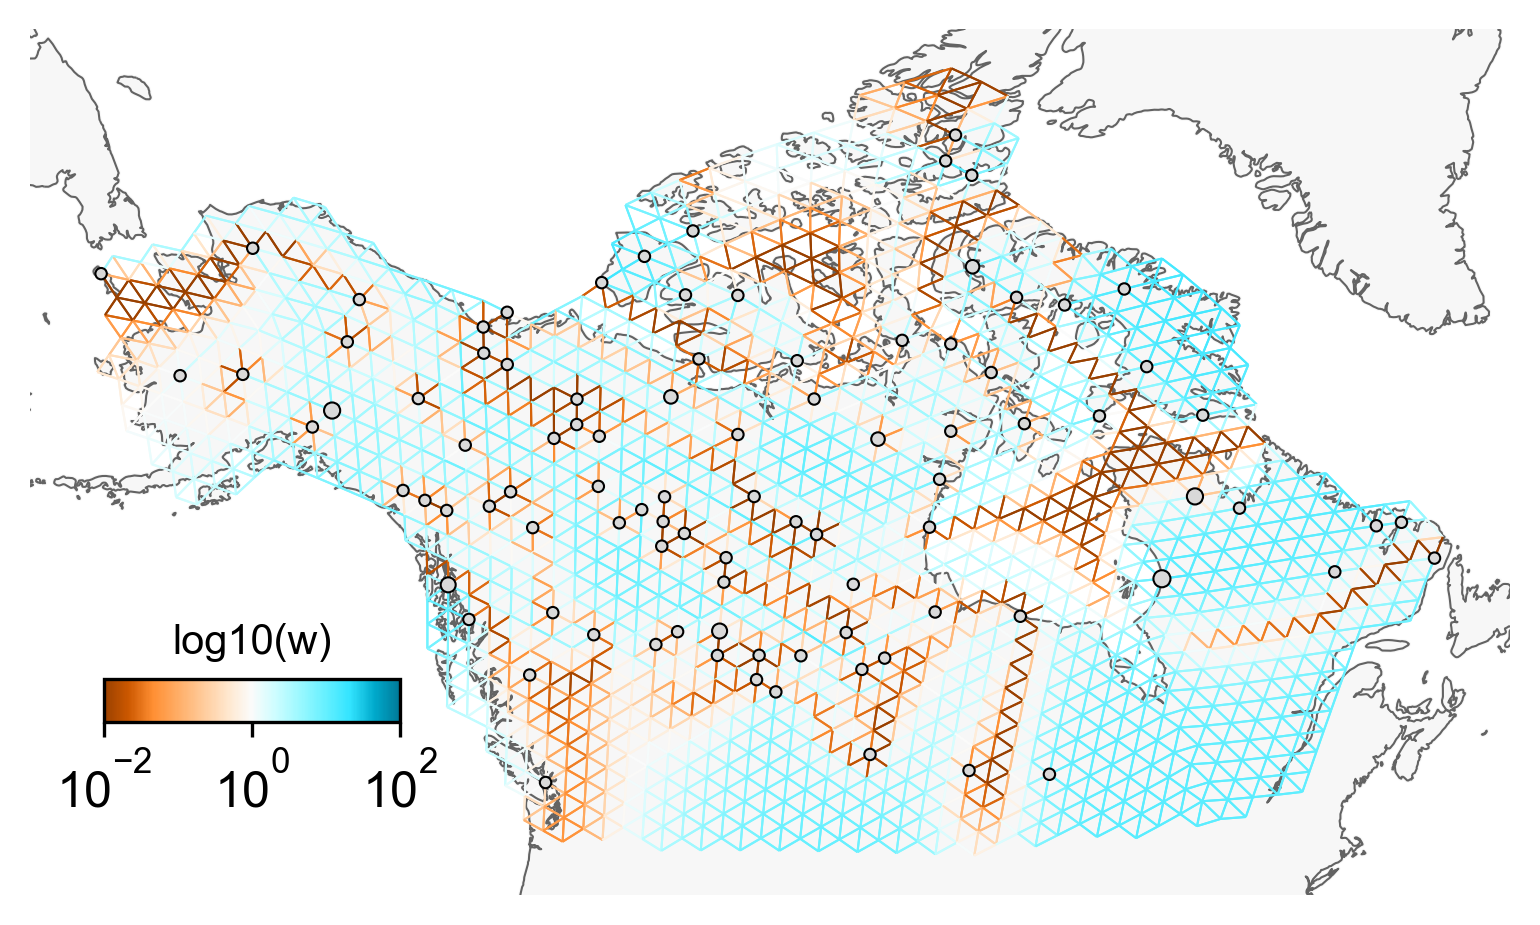

In [18]:
%%time
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(6, 6))
spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)

lamb=0.01
lamb_grid = np.linspace(lamb,lamb,1)
sp_graph.fit(lamb = lamb)


ax = fig.add_subplot(2, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

fittedVsObserved = False
if fittedVsObserved:
    ax1 = fig.add_subplot(2,1,2)  
    sp_graph.comp_graph_laplacian(sp_graph.w)
    obj = Objective(sp_graph)
    fit_cov, _, emp_cov = comp_mats(obj)
    fit_dist = cov_to_dist(fit_cov)[tril_idx]
    emp_dist = cov_to_dist(emp_cov)[tril_idx]
    X = sm.add_constant(fit_dist)
    mod = sm.OLS(emp_dist, X)
    res = mod.fit()
    muhat, betahat = res.params
    ax1.scatter(fit_dist,
                  emp_dist,
                  marker=".", 
                  alpha=1, 
                  zorder=0, 
                  color="black",
                  s=3)

    x = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
    ax1.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
    ax1.text(4.2, 2, "R²={:.4f}".format(res.rsquared))
    ax1.set_xlabel("fitted distance")
    ax1.set_ylabel("genetic distance")

CV = False
if CV:
    cv_err_0 = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e10)    
    mean_cv_err_0 = np.mean(cv_err_0, axis=0)
    mean_cv_err_0
    ax1.text(4.2, 1.5, "CV error={:.4f}".format(float(mean_cv_err_0)))




### Challenge exercises
- Using the plink files provided in the repository, run admixture and PCA on these data and compare the insights to population structure gained from each approach. (Hint: Also see the original Schweizer et al paper and supporting figures in Marcus et al). 
- Use plink to selectively drop samples from the dataset and see how it impacts the results.
- Use plink to subsample SNPs and see how it impacts the results.

### Closing

With this workshop you've gained some initial experience using `feems`.  While the cross-validation is time-consuming - individual fits are quick.  We encourage experimenting with inclusion/exclusion of samples or markers (and other perturbations) so that you can understand the method better and what signals are robustly found in your data. If you develop interestig ways of parsing the outputs, let us know via email or a pull request!